# Sequence Processing with HMMs and CRFs

**The goal of this practical is to study sequence models in NLP.**

We will work on Part-Of-Speech (POS) and optionally on chunking (gathering different groups in sentences). The datasets are from [CONLL 2000](https://www.clips.uantwerpen.be/conll2000/chunking/): 
- **Small corpus:** chtrain/chtest to understand the tools and models 
- **Larger corpus:** train/test to collect reliable experimental results


# 1) HMMS


In [40]:
import numpy as np
import matplotlib.pyplot as plt

In [41]:
# Loading POS/Chunking data
def load(filename):
    listeDoc = list()
    with open(filename, "r") as f:
        doc = list()
        for ligne in f:
            if len(ligne) < 2:  # fin de doc
                listeDoc.append(doc)
                doc = list()
                continue
            mots = ligne.replace("\n", "").split(" ")
            doc.append((mots[0], mots[1]))  # Change mots[1] -> mots[2] for chuncking
    return listeDoc

In [42]:
# =============== loding ============
# small corpus => ideal for first tests
# filename = "ressources/conll2000/chtrain.txt"
# filenameT = "ressources/conll2000/chtest.txt"

# Larger corpus => To valide perf.
filename = "ressources/conll2000/train.txt"
filenameT = "ressources/conll2000/test.txt"

alldocs = load(filename)
alldocsT = load(filenameT)

print(len(alldocs), " docs read")
print(len(alldocsT), " docs (T) read")

8936  docs read
2012  docs (T) read


In [43]:
print(alldocs[0])
print(alldocsT[0])

[('Confidence', 'NN'), ('in', 'IN'), ('the', 'DT'), ('pound', 'NN'), ('is', 'VBZ'), ('widely', 'RB'), ('expected', 'VBN'), ('to', 'TO'), ('take', 'VB'), ('another', 'DT'), ('sharp', 'JJ'), ('dive', 'NN'), ('if', 'IN'), ('trade', 'NN'), ('figures', 'NNS'), ('for', 'IN'), ('September', 'NNP'), (',', ','), ('due', 'JJ'), ('for', 'IN'), ('release', 'NN'), ('tomorrow', 'NN'), (',', ','), ('fail', 'VB'), ('to', 'TO'), ('show', 'VB'), ('a', 'DT'), ('substantial', 'JJ'), ('improvement', 'NN'), ('from', 'IN'), ('July', 'NNP'), ('and', 'CC'), ('August', 'NNP'), ("'s", 'POS'), ('near-record', 'JJ'), ('deficits', 'NNS'), ('.', '.')]
[('Rockwell', 'NNP'), ('International', 'NNP'), ('Corp.', 'NNP'), ("'s", 'POS'), ('Tulsa', 'NNP'), ('unit', 'NN'), ('said', 'VBD'), ('it', 'PRP'), ('signed', 'VBD'), ('a', 'DT'), ('tentative', 'JJ'), ('agreement', 'NN'), ('extending', 'VBG'), ('its', 'PRP$'), ('contract', 'NN'), ('with', 'IN'), ('Boeing', 'NNP'), ('Co.', 'NNP'), ('to', 'TO'), ('provide', 'VB'), ('struc

## Building a baseline POS model (without sequence)

We will build a simple dictionary ```word => PoS label``` without taking into account any sequence information. We will compare the sequence models to this baseline.

The dataset is a list a tuples with ```(word, POS)```. **Build a simple dictionary mapping each word to its PoS tag in the train set**

In [44]:
# Dictionary building
dico = dict()
# YOUR CODE HERE
for lines in alldocs:
    for words, tags in lines:
        dico[words] = tags

**Note: on the test set, there are unknown words...**. We will use the following simple strategy: 
```
# remplace
dico[cle] # crashing with an unknown key 
# by 
dico.get(cle, DefaultValue)
```
From a linguistic point of view, we can choose the default value as the majority PoS class, producing a stronger baseline.

In [45]:
# Evaluate test performances
score = 0
for lines in alldocsT:
    for words, tags in lines:
        if tags in dico.get(words, "NN"):
            score += 1
# TODO
# w = np.array(w)
# np.sum(np.where(w == "NN", 0, 1))
score

42474

Check: 1433 good predictions in test over 1896

(1527 with 'NN' as default PoS value)

## HMMs

Here is a code for training HMM parameters and running decoding using the Viterbi algorithm. You should apply it to our PoS task. **N.B.: you should undersand the ```eps``` parmaters**.


In [47]:
# allx: list of observation sequences
# allq: list os state sequences
# N: nb states
# K: nb observations


def learnHMM(allx, allq, N, K, initTo1=True):
    if initTo1:
        eps = 1e-3  # You can play with this regularization parameter
        A = np.ones((N, N)) * eps
        B = np.ones((N, K)) * eps
        Pi = np.ones(N) * eps
    else:
        A = np.zeros((N, N))
        B = np.zeros((N, K))
        Pi = np.zeros(N)
    for x, q in zip(allx, allq):
        Pi[int(q[0])] += 1
        for i in range(len(q) - 1):
            A[int(q[i]), int(q[i + 1])] += 1
            B[int(q[i]), int(x[i])] += 1
        B[int(q[-1]), int(x[-1])] += 1  # last transition
    A = A / np.maximum(A.sum(1).reshape(N, 1), 1)  # normalisation
    B = B / np.maximum(B.sum(1).reshape(N, 1), 1)  # normalisation
    Pi = Pi / Pi.sum()
    return Pi, A, B


def viterbi(x, Pi, A, B):
    T = len(x)
    N = len(Pi)
    logA = np.log(A)
    logB = np.log(B)
    logdelta = np.zeros((N, T))
    psi = np.zeros((N, T), dtype=int)
    S = np.zeros(T)
    logdelta[:, 0] = np.log(Pi) + logB[:, int(x[0])]
    # forward
    for t in range(1, T):
        logdelta[:, t] = (logdelta[:, t - 1].reshape(N, 1) + logA).max(0) + logB[:, int(x[t])]
        psi[:, t] = (logdelta[:, t - 1].reshape(N, 1) + logA).argmax(0)
    # backward
    logp = logdelta[:, -1].max()
    S[T - 1] = logdelta[:, -1].argmax()
    for i in range(2, T + 1):
        S[int(T - i)] = psi[int(S[int(T - i + 1)]), int(T - i + 1)]
    return S, logp  # , delta, psi

### Data encoding

We will map each word to an index for traing the HMM (see code below):
```
 The cat is in the garden => 1 2 3 4 1 5
```
We have to understand the dictionary functionning to retrieve the words corresponding to indices.

In [48]:
# alldocs etant issu du chargement des données
# la mise en forme des données est fournie ici
# afin de produire des analyses qualitative, vous devez malgré tout comprendre le fonctionnement des dictionnaires

buf = [[m for m, pos in d] for d in alldocs]
mots = []
[mots.extend(b) for b in buf]
mots = np.unique(np.array(mots))
nMots = len(mots) + 1  # mot inconnu

mots2ind = dict(zip(mots, range(len(mots))))
mots2ind["UUUUUUUU"] = len(mots)

buf2 = [[pos for m, pos in d] for d in alldocs]
cles = []
[cles.extend(b) for b in buf2]
cles = np.unique(np.array(cles))
cles2ind = dict(zip(cles, range(len(cles))))
nCles = len(cles)

print(f"{nMots} words, {nCles} keys in the dictionary")

# mise en forme des données
allx = [[mots2ind[m] for m, pos in d] for d in alldocs]
allxT = [[mots2ind.setdefault(m, len(mots)) for m, pos in d] for d in alldocsT]

allq = [[cles2ind[pos] for m, pos in d] for d in alldocs]
allqT = [[cles2ind.setdefault(pos, len(cles)) for m, pos in d] for d in alldocsT]

19123 words, 44 keys in the dictionary


In [49]:
# First doc:
print(allx[0])
print(allq[0])

[3068, 12557, 17919, 15074, 12916, 18921, 11125, 18064, 17758, 7826, 16693, 10436, 12470, 18146, 11397, 11597, 6398, 24, 10616, 11597, 15914, 18078, 24, 11229, 18064, 16777, 7393, 17545, 12552, 11752, 4554, 7798, 2331, 21, 14042, 10027, 31]
[18, 13, 10, 18, 38, 26, 36, 31, 33, 10, 14, 18, 13, 18, 21, 13, 19, 5, 14, 13, 18, 18, 5, 33, 31, 33, 10, 14, 18, 13, 19, 8, 19, 23, 14, 21, 6]


## You turn: apply HMMs to those data!

In [50]:
# HMM training
# YOUR CODE HERE
Pi, A, B = learnHMM(allx, allq, nCles, nMots)
print(Pi)
print(A)
print(B)

[1.12018249e-04 6.71549961e-04 4.47737276e-04 3.13348949e-03
 1.12018249e-04 1.11906342e-07 1.11906342e-07 2.12633241e-03
 5.61770958e-02 1.62265316e-02 2.12398350e-01 3.24539584e-03
 1.11906342e-07 1.28916218e-01 4.48745552e-02 1.11917533e-03
 4.92399097e-03 5.59643619e-04 4.52102743e-02 1.91919489e-01
 2.23924591e-04 4.36435855e-02 1.11906342e-07 1.11906342e-07
 5.83033163e-02 8.61690027e-03 6.03176305e-02 2.12633241e-03
 1.11906342e-07 1.11906342e-07 4.47737276e-04 3.35730218e-03
 6.71549961e-04 4.81208463e-03 1.11917533e-03 1.34288730e-02
 5.25971000e-03 3.35830934e-04 1.90251973e-03 7.83456303e-04
 3.24539584e-03 1.12018249e-04 6.37877343e-03 7.27392345e-02]
[[2.77438686e-05 2.77438686e-05 2.77438686e-05 ... 2.77438686e-05
  2.77438686e-05 2.77438686e-05]
 [5.71414204e-07 5.71414204e-07 5.71414204e-07 ... 5.71414204e-07
  5.71414204e-07 5.71414204e-07]
 [9.75567878e-07 9.76543446e-04 1.07322222e-02 ... 9.75567878e-07
  6.82995071e-03 1.07322222e-02]
 ...
 [2.85355553e-05 2.8535555

In [60]:
# HMM decoding and performances evaluation
# YOUR CODE HERE
etats_predits = []
for x in allxT:
    etats_predits.append(viterbi(x, Pi, A, B)[0])

score = 0
for i in range(len(etats_predits)):
    score += np.sum(etats_predits[i] == allqT[i])
print(score, "bonnes réponses")

43778 bonnes réponses
accuracy 2074070306


In [62]:
pred = np.concatenate(etats_predits).ravel()
q = np.concatenate(allqT).ravel()
score = np.sum(np.where(pred == q, 1, 0))
print(score, "bonnes réponses")
print("accuracy", score / len(pred))

43778 bonnes réponses
accuracy 0.9240348692403487


Check : 1564 in test

### Qualitative Analyis:

- With imshow on the parameters (ou d'un argsort), show what are the probable transition between labels.
- Visualize the confusion matrices to understand what is challenging in this task
- Find out examples that are corrected by Viterbi decoding



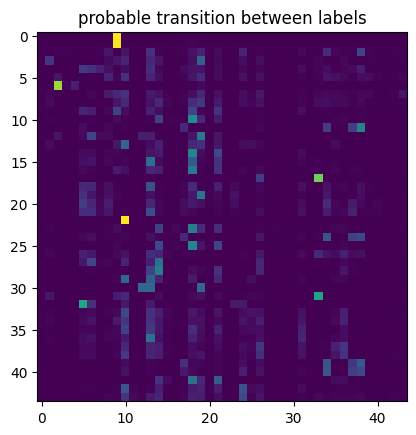

In [53]:
plt.imshow(A)
plt.title("probable transition between labels")
plt.show()

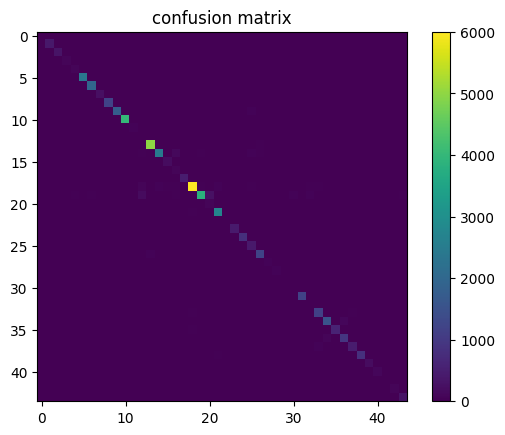

In [54]:
from sklearn.metrics import confusion_matrix

plt.imshow(confusion_matrix(q, pred))
plt.colorbar()
plt.title("confusion matrix")
plt.show()

# 2) Conditional Random Fields (CRF)

**CRF are disciminative models** representing the conditional distribution $P( \mathbf{y} | \mathbf{x} , \mathbf{w})$:

$$ P( \mathbf{y} | \mathbf{x} , \mathbf{w})  = \frac{e^{\mathbf{w}^T  \psi(\mathbf{x},\mathbf{y}) } }{\sum\limits_{y' \in \mathcal{y}}e^{\mathbf{w}^T  \psi(\mathbf{x},\mathbf{y}') } } $$ 
        
**In 'linear-chain' CRFs**, the feature functions include **unary terms $u_k$** ($\sim$ $\mathbf{B}$ matrix in HMMs) and **pairwise terms $p_k$** ($\sim$ $\mathbf{A}$ matrix in HMMs):

$$ \psi(\mathbf{x},\mathbf{y}) = \sum\limits_{t=1}^T \sum_{k=1}^K F_k(y_{t-1}, y_t, \mathbf{x})  =   \sum\limits_{t=1}^T \sum_{k=1}^K \left[ u_k(y_t, \mathbf{x}) + p_k(y_{t-1}, y_t, \mathbf{x}) \right]$$

[<img src="https://thome.isir.upmc.fr/classes/RITAL/crf-obs2.png" width="800" >](https://thome.isir.upmc.fr/classes/RITAL/crf-obs2.png)


We can directly use resources from nltk: 
- [CRFTagger](https://tedboy.github.io/nlps/generated/generated/nltk.CRFTagger.html)
- [PerceptronTagger](https://www.nltk.org/_modules/nltk/tag/perceptron.html)

In [55]:
# !pip install python-crfsuite
from nltk.tag.crf import CRFTagger

tagger = CRFTagger()
tagger.train(alldocs, "out/crf.model")  # training

In [56]:
score = tagger.accuracy(alldocsT)
print(f"accuracy {score} %")

accuracy 0.9627456360681343 %


In [59]:
len(pred) * score

45612.0

Check: 1720 bonnes réponses

### Training and evaluating the model, as before

In [57]:
# perceptron
from nltk.tag.perceptron import PerceptronTagger

tagger = PerceptronTagger(load=False)
tagger.train(alldocs)
tagger.accuracy(alldocsT)

0.9708719420816008

Check: 1737 bonnes réponses

# Going further

- We test the application for PoS, we can run similar experiments for chunking (see parsing indication, very simple to load data)
- Run  experiement on the larger dataset. This dataset is still largely used in research. This work can thus be included in your resume :)
- Work will be purshed with word embeddings (next practical), and for [NER](https://www.clips.uantwerpen.be/conll2003/ner/) with RNNs (X. Tannier)
- [State-of-the-art resources](https://github.com/stanfordnlp/stanza/)